In [1]:
import ctypes
libc = ctypes.CDLL("libc.so.6") # clearing cache 
libc.malloc_trim(0)

1

In [2]:
import gc 
gc.collect()


35

In [3]:
import seaborn as sns
sns.set()

# Image Classification with TensorFlow

Image classification is a common task for deep learning and neural networks.  The raw features coming in are the pixel values.  These are simple enough to deal with, but it is difficult to connect pixel values to determining whether an image is of a cat.  Older methods used a lot of clever filters, but the current best-of-breed algorithms simply throw a lot of linear algebra at the problem.

In this miniproject, you build a series of models to classify a series of images into one of ten classes. For expediency, these images are pretty small ($32\times32\times3$).  This can make classification a bit tricky&mdash;human performance is only about 94%.  Each of your models will be scored by comparing its accuracy to the accuracy of a reference model that we developed.  A score of 1 indicates that your model performs as well as the reference model; not that your accuracy is 100%!

You will be given both a training set and a validation set.  Ground truth values are provided for the training set.  You should train your models on this set, and then make predictions for each of the validation images.  These predictions will be submitted to the grader.

## A note on scoring

It **is** possible to score above 1 on these questions. This indicates that you've beaten our reference model&mdash;we compare our model's score on a test set to your score on a test set. See how high you can go!

## Downloading the data

We will be using the `CIFAR-10` data set.  It consists of 60,000 images, each $32\times32$ color pixels, each belonging to one of ten classes.  The following cell will download the data, in NumPy's `.npy` format.

In [5]:
!aws s3 sync s3://dataincubator-course/cifar10/ .

We can load in the data like so:

In [6]:
import numpy as np
import gzip

train_images = np.load(gzip.open('train_images.npy.gz', 'rb'))
train_labels = np.load(gzip.open('train_labels.npy.gz', 'rb'))
validation_images = np.load(gzip.open('validation_images.npy.gz', 'rb'))

The images are stored as four-dimensional arrays.  The first index indicates the image number, the second and third the $x$ and $y$ positions, and the fourth index the color channel.  Each pixel color is a floating point number between 0 and 1.  This convention allows us to view the images with matplotlib:

In [61]:
train_images.shape

(50000, 32, 32, 3)

In [62]:
train_images.reshape(50000,-1).shape

(50000, 3072)

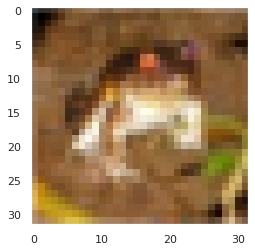

In [63]:
import matplotlib.pyplot
matplotlib.pyplot.rcParams["axes.grid"] = False  #  Remove the grid lines from the image.
matplotlib.pyplot.imshow(train_images[0])

The classes have already been numbered 0-9 for us; those numbers are stored in the vector `train_labels`.

In [64]:
train_labels[0]

6

The human-readable names associated with this classes are

In [65]:
label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

In [66]:
label_names[train_labels[0]]

'frog'

# Questions

## Perceptual Delta

Since we already have a number of labeled images, a simple approach would be to measure the difference between two images, and choose the label corresponding to nearby images.  To do this, we need to develop a metric to determine the distance between two images.  We'll make the simplifying (and completely wrong) assumption that this is just the average difference between the colors of the corresponding pixels in the two images.

While we could just take RMS difference of the red, green, and blue pixels, let's be slightly more sophisticated and look at human vision for a metric.  After all, we're pretty good at image classifications, so there might be some useful optimization here.

It turns out that modeling human perception is [extraordinarily complicated](https://en.wikipedia.org/wiki/Color_difference#CIEDE2000).  We're going to use a [simplified model](https://www.compuphase.com/cmetric.htm):

$$\Delta C \equiv \sqrt{2 \Delta R^2 + 4 \Delta G^2 + 3 \Delta B^2 + \bar R\left(\Delta R^2 - \Delta B^2 \right)} $$
where $(R_1, G_1, B_1)$ and $(R_2, G_2, B_2)$ are the RGB components of the two colors and
$$\begin{align}
\Delta R &= R_1 - R_2 \\
\Delta G &= G_1 - G_2 \\
\Delta B &= B_1 - B_2 \\
\bar R &= \textstyle\frac{1}{2}\left(R_1 + R_2\right)
\end{align}$$

This accounts for the fact that our eyes are most sensitive to green and least sensitive to red, and that perception is not constant with hue.

Build a graph that takes in a series of images, as well as a base image, and returns a result containing the $\Delta C$ value (for each pixel) between the base image and each image in the series.  

(Note that the intention here in our solution is that `images` will be a stack of images, while `base` is a single image.  Since the function is decorated with `tf.function` the computations within the function will be recorded in a computation graph and the output from this function will be a tensor.)

In [4]:
import tensorflow as tf

   

@tf.function
def c_delta(m,n):
    r_2 = tf.square(tf.subtract(m[:,:,0], n[:,:,0]))
    g_2 = tf.square(tf.subtract(m[:,:,1], n[:,:,1]))
    b_2 = tf.square(tf.subtract(m[:,:,2], n[:,:,2]))
    r_bar = tf.divide(tf.add(m[:,:,0], n[:,:,0]),2)
    c_delta = tf.sqrt(2*r_2 + 4*g_2 + 3*b_2 + r_bar*(r_2-b_2))
    return tf.reduce_sum(c_delta)/(32*32)



As stated, for two images, $I_1$ and $I_2$, we define the distance between $I_1$ and $I_2$ as the average $\Delta C$ value over the whole image, that is:

$$d(I_1, I_2) = \frac{1}{N}\sum_{p_j} \Delta C(p_j)$$
where the sum is over all pixels $p_j$, $\Delta C(p_2)$ is the $\Delta C$ value for the pixel $p_j$, and $N$ is the total number of pixels in each image ($N= 32\times 32$ in our case).

Using `delta_func` compute the distance between the first validation image and all of the training images.

**Checkpoint:** The mean value of the distances is 1.159, and the standard deviation of the distances is 0.182.

In [5]:
@tf.function
def delta_func(images, base):
    return tf.map_fn(lambda x: c_delta(x,base),images)

In [6]:
deltas = delta_func(train_images, validation_images[0])
nums = deltas.numpy()

From these, find the 100 closest images from the training set to this first validation image.  (Note that `numpy.argsort` might help here.)  Submit a list of the indices of these images to the grader.

In [1]:
indices = list(nums.argsort()[:100])


NameError: name 'nums' is not defined

**Extension:** What does this suggest about the proper class for this image?

> **Aside:** Essentially, we've started to implement a $k$-nearest neighbors algorithm, using this perceptual distance as our metric.  If we ran the difference between all of the validation images and each of the training images, we could make a prediction from the nearest images for each.  Give it a try, if you're interested, but this miniproject is going to go in another direction.

## Softmax model

We could use this delta function to measure distances from images with known classes, but that's not really the Deep Learning Way (TM).  Instead, we'll let neural networks figure out how to connect pixel values to classes.

We'll start with something that barely qualifies as a neural network: a softmax classifier.  This has no hidden layers; instead a single dense layer takes $32\times32\times3$ inputs and produces 10 outputs, one for each class.  It should use a softmax activation and a `CategoricalCrossentropy` loss function.

Build such a model and train it on the training data.  Then use this model to make a prediction on each of the 10,000 validation images.

**Hints:**
- The labels are given as integers, but softmax expects one-hot encoding of the labels.  The `tf.one_hot` function can do the conversion.
- TensorFlow's `.predict` method will return probabilities for each image being in each class, but the grader wants only the class prediction.  You may find the `np.argmax` function helpful in determining the class with the highest probability.

In [6]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [9]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(32, 32, 3)),
    tf.keras.layers.Dense(10, activation='softmax'),
#     tf.keras.layers.Dense(10)
])

In [10]:
model.compile(
              
#               loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [7]:
y_train = tf.one_hot(train_labels, 10).numpy()

In [8]:
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [13]:

model.fit(train_images, y_train, epochs=5)

Epoch 1/5
1563/1563 [==============================] - 2s 1ms/step - loss: 1.9597 - accuracy: 0.3162
Epoch 2/5
1563/1563 [==============================] - 2s 1ms/step - loss: 1.8868 - accuracy: 0.3498
Epoch 3/5
1563/1563 [==============================] - 2s 1ms/step - loss: 1.8544 - accuracy: 0.3639
Epoch 4/5
1563/1563 [==============================] - 2s 1ms/step - loss: 1.8448 - accuracy: 0.3676
Epoch 5/5
1563/1563 [==============================] - 2s 1ms/step - loss: 1.8343 - accuracy: 0.3726


In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 3072)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                30730     
Total params: 30,730
Trainable params: 30,730
Non-trainable params: 0
_________________________________________________________________


In [15]:
predicted_classes = np.argmax(model.predict(validation_images), axis=1)

In [2]:
predicted_classes = list(predicted_classes)


NameError: name 'predicted_classes' is not defined

## Fully-connected model

Now, add a hidden layer to this network.  Train this network on the pixel values, and once again use it to predict the most likely class for each of the validation images.

**Hints:**
- We found that adding more layers didn't help too much.
- Watch out for overfitting.  Dropout can help with this.
- The reference solution achieves an accuracy of about 44% on a training set and 41% on a test set.

In [17]:
32*32*3

3072

In [18]:
model_2 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(32, 32, 3)),
    tf.keras.layers.Dense(3072, activation='sigmoid'),
    tf.keras.layers.Dense(10, activation='softmax'),
#     tf.keras.layers.Dense(10)
])

In [19]:
model_2.compile(
              
#               loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [20]:
model_2.fit(train_images, y_train, epochs=5)

Epoch 1/5
1563/1563 [==============================] - 37s 24ms/step - loss: 1.9506 - accuracy: 0.3093
Epoch 2/5
1563/1563 [==============================] - 37s 24ms/step - loss: 1.7803 - accuracy: 0.3596
Epoch 3/5
1563/1563 [==============================] - 37s 24ms/step - loss: 1.7365 - accuracy: 0.3768
Epoch 4/5
1563/1563 [==============================] - 37s 24ms/step - loss: 1.7103 - accuracy: 0.3876
Epoch 5/5
1563/1563 [==============================] - 37s 24ms/step - loss: 1.6918 - accuracy: 0.3975


In [21]:
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 3072)              9440256   
_________________________________________________________________
dense_2 (Dense)              (None, 10)                30730     
Total params: 9,470,986
Trainable params: 9,470,986
Non-trainable params: 0
_________________________________________________________________


In [22]:
predicted_classes = np.argmax(model_2.predict(validation_images), axis=1)

In [3]:

predicted_classes = list(predicted_classes)


NameError: name 'predicted_classes' is not defined

## Convolutional model

Convolutional neural networks have had a lot of success in image classification.  Build a neural network with convolutional layers to improve the performance.

**Hints:**
- The reference solution uses two convolutional layers and two fully-connected layers.
- We found success with the `AdamOptimizer`.
- The reference solution achieves an accuracy of roughly 80% on a training set and 70% on a test set.

In [17]:
img_size = 32
img_size_flat = img_size * img_size
img_shape = (img_size, img_size)

n_classes = 10
n_channels = 3
filt_size = [8, 8] # 5x5 pixel filters

batch_size = 50
n_epochs = 30

In [8]:
model_cnn = keras.models.Sequential()

model_cnn.add(keras.layers.Reshape([img_size, img_size, n_channels]))
model_cnn.add(keras.layers.Conv2D(32, (3, 3), padding='same',
                              activation='relu'))

model_cnn.add(keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2),
                                    padding='same'))

model_cnn.add(keras.layers.Conv2D(64, (3, 3), padding='same',
                              activation='relu'))

model_cnn.add(keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2),
                                    padding='same'))

# model_cnn.add(keras.layers.Dropout(0.5))

model_cnn.add(keras.layers.Flatten())

model_cnn.add(keras.layers.Dense(100, activation='relu'))

model_cnn.add(keras.layers.Dense(n_classes, activation='softmax'))

In [9]:
model_cnn.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [13]:
model_cnn.fit(train_images, y_train, epochs=n_epochs, batch_size=batch_size)

Epoch 1/5
1000/1000 [==============================] - 30s 30ms/step - loss: 1.3913 - accuracy: 0.5061
Epoch 2/5
1000/1000 [==============================] - 29s 29ms/step - loss: 1.0409 - accuracy: 0.6371
Epoch 3/5
1000/1000 [==============================] - 29s 29ms/step - loss: 0.9124 - accuracy: 0.6828
Epoch 4/5
1000/1000 [==============================] - 29s 29ms/step - loss: 0.8275 - accuracy: 0.7106
Epoch 5/5
1000/1000 [==============================] - 29s 29ms/step - loss: 0.7566 - accuracy: 0.7367


In [14]:
model_cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (50, 32, 32, 3)           0         
_________________________________________________________________
conv2d (Conv2D)              (50, 32, 32, 32)          896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (50, 16, 16, 32)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (50, 16, 16, 64)          18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (50, 8, 8, 64)            0         
_________________________________________________________________
flatten (Flatten)            (50, 4096)                0         
_________________________________________________________________
dense (Dense)                (50, 100)                 4

In [15]:
predicted_classes = np.argmax(model_cnn.predict(validation_images), axis=1)

In [4]:

predicted_classes = list(predicted_classes)

NameError: name 'predicted_classes' is not defined

## Transfer learning

In transfer learning, we use a network trained on one data set to provide a starting point for the modeling of other data.  As we are trying to model color images, we should look for another network trained on color images.  Luckily, we have already discussed such a network: the Inception network used in the Deep Dream notebook.

The following cell will load the model, omitting its classification layer (since we're not interested in classifying `ImageNet` images).

In [9]:
# include_top=False will discard avg_pool before prediction layer
inception = tf.keras.applications.inception_v3.InceptionV3(include_top=True, input_shape=(299, 299, 3))
inception = tf.keras.Model([inception.input], [inception.layers[-2].output]) # manually discard prediction layer

In a transfer learning setup, we will use the first part of the trained network to process the original images, and then train a network to make predictions from the output of the trained network.  There are several ways to accomplish this.

One approach is to connect the new layers to the output of the existing layers.  Data will flow through the pre-trained layers as well as those added.  In the training step, only the new layers should be marked as trainable.

However, this can be a bit wasteful when multiple epochs of training will be undertaken since we recalculate the latent vectors on every training step.  With a smaller data set, such as this, it can be more efficient to pre-calculate the *latent vectors* that are the output of the pre-trained network.  These can be stored and used as input for training a smaller, separate network to make the predictions.  We recommend this approach for this miniproject.

Images should be fed to the `inception` network and then vectorized (you might want to refer to the `TF_DeepDream.ipynb` notebook).

We've loaded the `inception` network with its native image shape: $299 \times 299$.  This implies that we need to upscale our images from $32\times32$ to $299\times299$.  There are a number of ways to do this; the reference solution uses `tf.image.resize` with bilinear interpolation.  (More sophisticated resizing methods produce better results, but will take significantly longer!)

It may make sense to do the rescaling and latent vector calculation at the same time, to avoid storing the (somewhat large) rescaled images unnecessarily.  You also probably want to save those latent vectors to disk, to avoid the need to repeat this calculation later.

**Hints:**
- Be sure to batch this calculation; resizing all 50,000 images at once will cause memory errors.
- The latent vector calculation took us between 30 minutes and 2 hours on a single machine.  You might consider distributing the calculation.
- The latent vectors for the first 10 images have an average of 1983 non-zero values and an overall average value of 0.319.

With the latent vectors calculated, we can use them as input to train a small neural network to make the final predictions.

**Hints:**
- The reference solution has three layers.
- The reference solution achieves a training accuracy of 87% and a test accuracy of 85%.

In [10]:

# for batch in range(50):
#     train_subset = train_images[(batch * 1000):(batch + 1) * 1000]
#     resized_images = tf.image.resize(train_subset,[299, 299])
#     inception_pred = inception.predict(resized_images)
#     with open('batch_{}.npy'.format(batch), 'wb') as f:
#         np.save(f, inception_pred)
# #     np.save(f"batch_{batch}", arr_to_save)
#     del inception_pred
#     del resized_images
#     del train_subset
#     gc.collect()
#     libc.malloc_trim(0)
#     print(batch)

In [11]:
# for batch in range(10):
#     val_subset = validation_images[(batch * 1000):(batch + 1) * 1000]
#     resized_images = tf.image.resize(val_subset,[299, 299])
#     inception_pred = inception.predict(resized_images)
#     with open('val_batch_{}.npy'.format(batch), 'wb') as f:
#         np.save(f, inception_pred)
# #     np.save(f"val_batch_{batch}", arr_to_save)
#     del inception_pred
#     del resized_images
#     del val_subset
#     gc.collect()
#     libc.malloc_trim(0)
#     print(batch)

In [10]:
inception.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [11]:
#load all files together
train_latent = None
for batch in range(50):
    a = np.load(open("batch_{}.npy".format(batch),'rb'))
    if train_latent is None:
        train_latent = a
    else:
        train_latent = np.concatenate((train_latent, a), axis=0)  


In [105]:
#load vali files together
validation_latent = None
for batch in range(10):
    b = np.load(open("val_batch_{}.npy".format(batch),'rb'))
    if validation_latent is None:
        validation_latent = b
    else:
        validation_latent = np.concatenate((validation_latent, b), axis=0)  
    

In [104]:
val_subset = validation_images[0:10]
resized_images = tf.image.resize(val_subset,[299, 299])
inception_pred = inception.predict(resized_images)
inception_pred[0]

array([0.1667909 , 0.04119096, 0.21842594, ..., 0.19361416, 0.18005972,
       0.04173461], dtype=float32)

In [39]:

y_train = train_labels[:48000]

X_train = train_latent[:48000]

X_test = train_latent[48000:]
y_test = train_labels[48000:]
                          
from tensorflow.keras.utils import to_categorical as one_hot

y_train_hot = one_hot(y_train)
y_test_hot = one_hot(y_test)  

In [13]:
N_PIXELS= 299 * 299 * 3
N_CLASSES = 10

n_epochs = 10
hidden_size = 64
batch_size = 128

In [71]:

model = keras.models.Sequential()

model.add(
    keras.layers.Dense(
        hidden_size,
        activation='sigmoid',
        use_bias=True,  # The default
        kernel_initializer=keras.initializers.TruncatedNormal(stddev=N_PIXELS**-0.5)
    )
)

model.add(
    keras.layers.Dense(
        10,
        activation='softmax',
        kernel_initializer=keras.initializers.TruncatedNormal(stddev=hidden_size**-0.5)
    )
)


model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.SGD(learning_rate=0.5),
              metrics=['accuracy'])

In [72]:
model.fit(X_train, y_train_hot,
                    epochs=10,
                    batch_size=128,
                    validation_data=(X_test,y_test_hot))

Epoch 1/10
375/375 [==============================] - 1s 2ms/step - loss: 0.7857 - accuracy: 0.7332 - val_loss: 0.5185 - val_accuracy: 0.8315
Epoch 2/10
375/375 [==============================] - 1s 2ms/step - loss: 0.5220 - accuracy: 0.8190 - val_loss: 0.5166 - val_accuracy: 0.8240
Epoch 3/10
375/375 [==============================] - 1s 2ms/step - loss: 0.4714 - accuracy: 0.8351 - val_loss: 0.4592 - val_accuracy: 0.8505
Epoch 4/10
375/375 [==============================] - 1s 2ms/step - loss: 0.4375 - accuracy: 0.8475 - val_loss: 0.4496 - val_accuracy: 0.8500
Epoch 5/10
375/375 [==============================] - 1s 2ms/step - loss: 0.4161 - accuracy: 0.8542 - val_loss: 0.4378 - val_accuracy: 0.8540
Epoch 6/10
375/375 [==============================] - 1s 2ms/step - loss: 0.3973 - accuracy: 0.8614 - val_loss: 0.4232 - val_accuracy: 0.8530
Epoch 7/10
375/375 [==============================] - 1s 2ms/step - loss: 0.3802 - accuracy: 0.8655 - val_loss: 0.4539 - val_accuracy: 0.8380
Epoch 

In [106]:
predicted_classes = np.argmax(model.predict(validation_latent),axis=1)

In [107]:
len(predicted_classes)

10000

In [5]:
predicted_classes = list(predicted_classes)


NameError: name 'predicted_classes' is not defined

*Copyright &copy; 2021 Pragmatic Institute. This content is licensed solely for personal use. Redistribution or publication of this material is strictly prohibited.*